<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

Пространство решающих деревьев. Размерность равна количеству неизоморфных деревьев глубины не более max_depth.

**Вопрос 2**: Почему бустинг над глубокими деревьями это плохая идея?
Из-за переобучения, так как в данном случае мы слишком подгоняемся под обучающую выборку.

**Вопрос 3**: Что предсказывает каждое дерево (что является признаками а что целевой переменной?)
Каждое дерево предсказывает "разницу" предыдущего дерева и ответов. Признаки - матрица исходных признаков. Целевая переменная - разница истинного ответа и ответа предыдущего дерева. 

<h1 align="center">Binary Boosting Implementation</h1> 

Давайте вспомним бустинг

#### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 

$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

#### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Алгоритм**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - $\hat{y} = \sum_{j=0}^{i-1} a_j b_j(x)$
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$ (Тут дерево не глубокое регрессионное дерево)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + lr * b_i(x)$
    
    
#### Нужно реализовать двух классовый бустинг с логистической функцией потерь.     

**Функция потерь**:
Я вот думаю, что всем интересно какую-же функцию потерь выбрать $\mathcal{L}(\hat{y},y)=\log\left( 1 + e^{-\hat{y}y} \right)$

тут важный момент есть, даже не один
- $\hat{y}$ -- это ответ композиции, тоесть сумма ответов всех предыдущих деревьев
- Это скалярная функция и производная халява, но вот тут мы вам посчитали $$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{1 + e^{-y\hat{y}}} \cdot (-ye^{-y\hat{y}})=-y\frac{1}{1 + e^{y\hat{y}}}$$

In [15]:
%pylab inline

import warnings
import numpy as np
import scipy as sp
from scipy import special
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.cross_validation import train_test_split

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [16]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
    
    def loss_grad(self, original_y, pred_y):        
        # Функция должна вернуть вектор длины = len(pred_y)
        # В каждом элементе вектора должно быть значение градиента dL(pred_y, original_y) / d pred_y[i]
        return - original_y * sp.special.expit(- original_y.dot(pred_y))# Градиент на каждом объекте
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = []
        _estimator = DecisionTreeRegressor(max_depth= 10); 
        for i in range(1,self.n_estimators):
            grad = self.loss_grad(original_y, self._predict(X))
            # Настройте базовый алгоритм на градиент, это классификация или регрессия?
            estimator = _estimator.fit(X,- grad)
            self.estimators_.append(estimator)
        return self

    def _predict(self, X):
        # Эта штука как раз должна вернуть сумму ответов всех алгоритмов 
        # Не забудьте про ленинг рейт
        y_pred = np.zeros(X.shape[0], dtype= 'float64')
        for i in self.estimators_[:-1]:
            y_pred += i.predict(X) * (np.random.random_sample() * 0.1)
        if (len(self.estimators_) > 0):
            y_pred += self.lr * self.estimators_[-1].predict(X)
        return y_pred
    
    def predict(self, X):
        # А тут на выходе должны быть классы, подумайте как это сделать
        y_pred = np.sign(self._predict(X))
        return y_pred

<h1 align="center">Simple test</h1> 

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

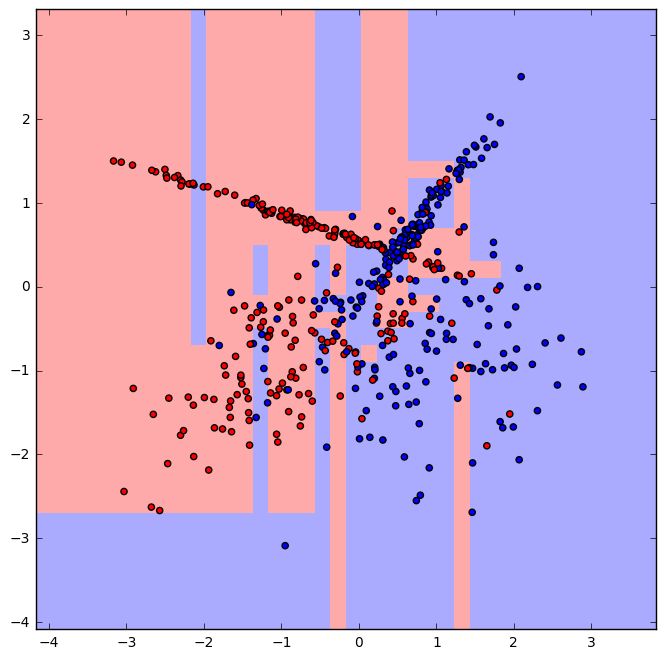

In [18]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
clf.predict(X)
plot_surface(X, y, clf)

In [19]:
pred_y = clf.predict(X)
print('test acc = %s' % acc(pred_y, y))

test acc = 0.99


<h1 align="center">Adult test</h1> 

In [193]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data > adult.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 3881k    1 65536    0     0  44643      0  0:01:29  0:00:01  0:01:28 44643
 10 3881k   10  416k    0     0   171k      0  0:00:22  0:00:02  0:00:20  171k
 53 3881k   53 2064k    0     0   608k      0  0:00:06  0:00:03  0:00:03  608k
 67 3881k   67 2624k    0     0   599k      0  0:00:06  0:00:04  0:00:02  599k
 69 3881k   69 2704k    0     0   503k      0  0:00:07  0:00:05  0:00:02  551k
100 3881k  100 3881k    0     0   624k      0  0:00:06  0:00:06 --:--:--  803k


#### Скачайте https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [20]:
adult = pd.read_csv(
    'adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [21]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)
X.shape


(32561L, 108L)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train


array([[  4.40000000e+01,   2.79183000e+05,   1.00000000e+01, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.80000000e+01,   1.15443000e+05,   7.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.90000000e+01,   3.40534000e+05,   9.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  3.20000000e+01,   1.31534000e+05,   9.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.10000000e+01,   1.56763000e+05,   9.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.10000000e+01,   6.66240000e+04,   1.30000000e+01, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [23]:
clf_1.predict(X_train[0:10,:])
#plot_surface(X_train[0:10,:],clf_1.predict(X_train[0:10,:]), clf_1)

NameError: name 'clf_1' is not defined

In [24]:
clf_1 = BinaryBoostingClassifier(n_estimators = 200).fit(X_train, y_train)

#<Сверьте качество своего алгоритма с GradientBoostingClassifier, оно должно быть примерно таким-же>

In [25]:
print('train acc = ', acc(clf_1.predict(X_train), y_train), 'test acc = %s' % acc(clf_1.predict(X_test), y_test))

('train acc = ', 0.87305487305487306, 'test acc = 0.853580641199')


<h1 align="center">Сдача ДЗ</h1> 

Заполните форму https://goo.gl/forms/sPE6gpRDNTOXQai12 
    - Качество вашего алгоритма на adult, один знак после запятой, без округления (0.86 -> 0.8 и тд) точность
    - BinaryBoostingClassifier.loss_grad ([-1, 1, 1], [-1, 1, -1]).sum()

In [27]:
BinaryBoostingClassifier.loss_grad(clf, np.array([-1, 1, 1]), np.array([-1, 1, -1])).sum()

-0.2689414213699951